### 元のサンプルソース
https://github.com/thinkitcojp/TensorFlowDL-samples/blob/master/board/mnist.py


In [22]:
from tensorflow.examples.tutorials.mnist import input_data
import tensorflow as tf

In [5]:
# tensorflowのメソッド経由でmnistのデータを取得しオブジェクトに格納する
mnist = input_data.read_data_sets("data/", one_hot=True)

Successfully downloaded train-images-idx3-ubyte.gz 9912422 bytes.
Extracting data/train-images-idx3-ubyte.gz
Successfully downloaded train-labels-idx1-ubyte.gz 28881 bytes.
Extracting data/train-labels-idx1-ubyte.gz
Successfully downloaded t10k-images-idx3-ubyte.gz 1648877 bytes.
Extracting data/t10k-images-idx3-ubyte.gz
Successfully downloaded t10k-labels-idx1-ubyte.gz 4542 bytes.
Extracting data/t10k-labels-idx1-ubyte.gz


In [6]:
# 入力データを定義
x = tf.placeholder(tf.float32, [None, 784])

In [7]:
# 入力画像をログに出力
img = tf.reshape(x, [-1, 28, 28, 1])
# 第一引数: 登録名
# 第二引数: 画像群
# 第三引数: 最大で何枚の画像をログに記録するか
tf.summary.image("input_data", img, 10)

<tf.Tensor 'input_data:0' shape=() dtype=string>

- Imagesは画像を表示する機能
    - 用途はバイナリデータの確認
    - 回転やノイズを与えて画像を擬似的に増やすなど
- 画像群として扱うには[ミニバッチサイズ、縦、横、チャンネル数]の4階テンソルである必要がある
    - そのため、元画像と同じ28*28の1チャンネル画像にreshapeしている
    - ※ 第一引数の-1はなんだ？
- チャンネル数は1, 3, 4のいずれか
    - 1: グレースケール
    - 3: RGB画像
    - 4: RGBA画像

In [12]:
# 入力層から中間層
with tf.name_scope("hidden"):
    w_1 = tf.Variable(tf.truncated_normal([784, 64], stddev=0.1), name="w1")
    b_1 = tf.Variable(tf.zeros([64]), name="b1")
    h_1 = tf.nn.relu(tf.matmul(x, w_1) + b_1)
    
    # 中間層の重み分布をログに出力
    tf.summary.histogram('w_1', w_1)

### name_scope
- `tf.summary.histogram('w_1', w_1)`
- 処理単位にブロックを分けることで計算グラフを可視化するときの粒度もこの処理単位に分けることができる

In [14]:
#中間層から出力層
with tf.name_scope("output"):
    w_2 = tf.Variable(tf.truncated_normal([64, 10], stddev=0.1), name="w2")
    b_2 = tf.Variable(tf.zeros([10]), name="b2")
    out = tf.nn.softmax(tf.matmul(h_1, w_2) + b_2)
    
y = tf.placeholder(tf.float32, [None, 10])

In [15]:
#誤差関数
with tf.name_scope("loss"):    
    loss = tf.reduce_mean(tf.square(y - out))

    #誤差をログ出力
    tf.summary.scalar("loss", loss)

### Scalars
- `tf.summary.scalar("loss", loss)`
- 誤差や精度がどのように変化していくかのログを取得する
- 入力はスカラ(0階テンソル)でなければならない

### Histograms/Distributions
- スカラでない値を分布として表示する場合は、tf.summary.histogramを用いる
    - 数値データのTensorであれば何階TensorでもOK
    - Nan値が入るとエラーになる
- Histograms: ステップの度数分布を確認できる
- Distributions: 確率分布を表し、その遷移を時間軸ごとに見ることができる

In [16]:
#訓練
with tf.name_scope("train"):
    train_step = tf.train.GradientDescentOptimizer(0.5).minimize(loss)

In [17]:
#評価
with tf.name_scope("accuracy"):
    correct = tf.equal(tf.argmax(out,1), tf.argmax(y,1))
    accuracy = tf.reduce_mean(tf.cast(correct, tf.float32))

    #精度をログ出力
    tf.summary.scalar("accuracy", accuracy)

In [18]:
#初期化
init =tf.global_variables_initializer()

summary_op = tf.summary.merge_all()

### ログのマージ
- 今までに仕込んだログを全てマージして、1回の実行で全てのログを取得するオペレーション

```
# 一部のログをmerge
merge = tf.summary.merge([a, b, c])

# 全てのログをマージ
summary_op = tf.summary.merge_all()
```

In [19]:
with tf.Session() as sess:
    # 第一引数はログ出力対象のディレクトリ
    summary_writer = tf.summary.FileWriter("logs", sess.graph)

    sess.run(init)    

    #テストデータをロード    
    test_images = mnist.test.images    
    test_labels = mnist.test.labels    
    
    for step in range(1000):        
        train_images, train_labels = mnist.train.next_batch(50)
        sess.run(train_step, feed_dict={x:train_images ,y:train_labels})

        if step % 10 == 0:
            #ログを取る処理を実行する（出力はログ情報が書かれたプロトコルバッファ）
            summary_str = sess.run(summary_op, feed_dict={x:test_images, y:test_labels})
            #ログ情報のプロトコルバッファを書き込む
            summary_writer.add_summary(summary_str, step)


### ログの書き込み
- `tf.summary.FileWriter("logs", sess.graph)`
- tf.summary.FileWriterを使うとログファイルを書き出せる

### Tensorbordの起動

```
$tensorboard --logdir ./logs
```

- tensorbord 1.5.1でMacだとうごかなかった
    - https://github.com/tensorflow/tensorboard/issues/1111
    - ここみてnightlyをインストールしたら行けた

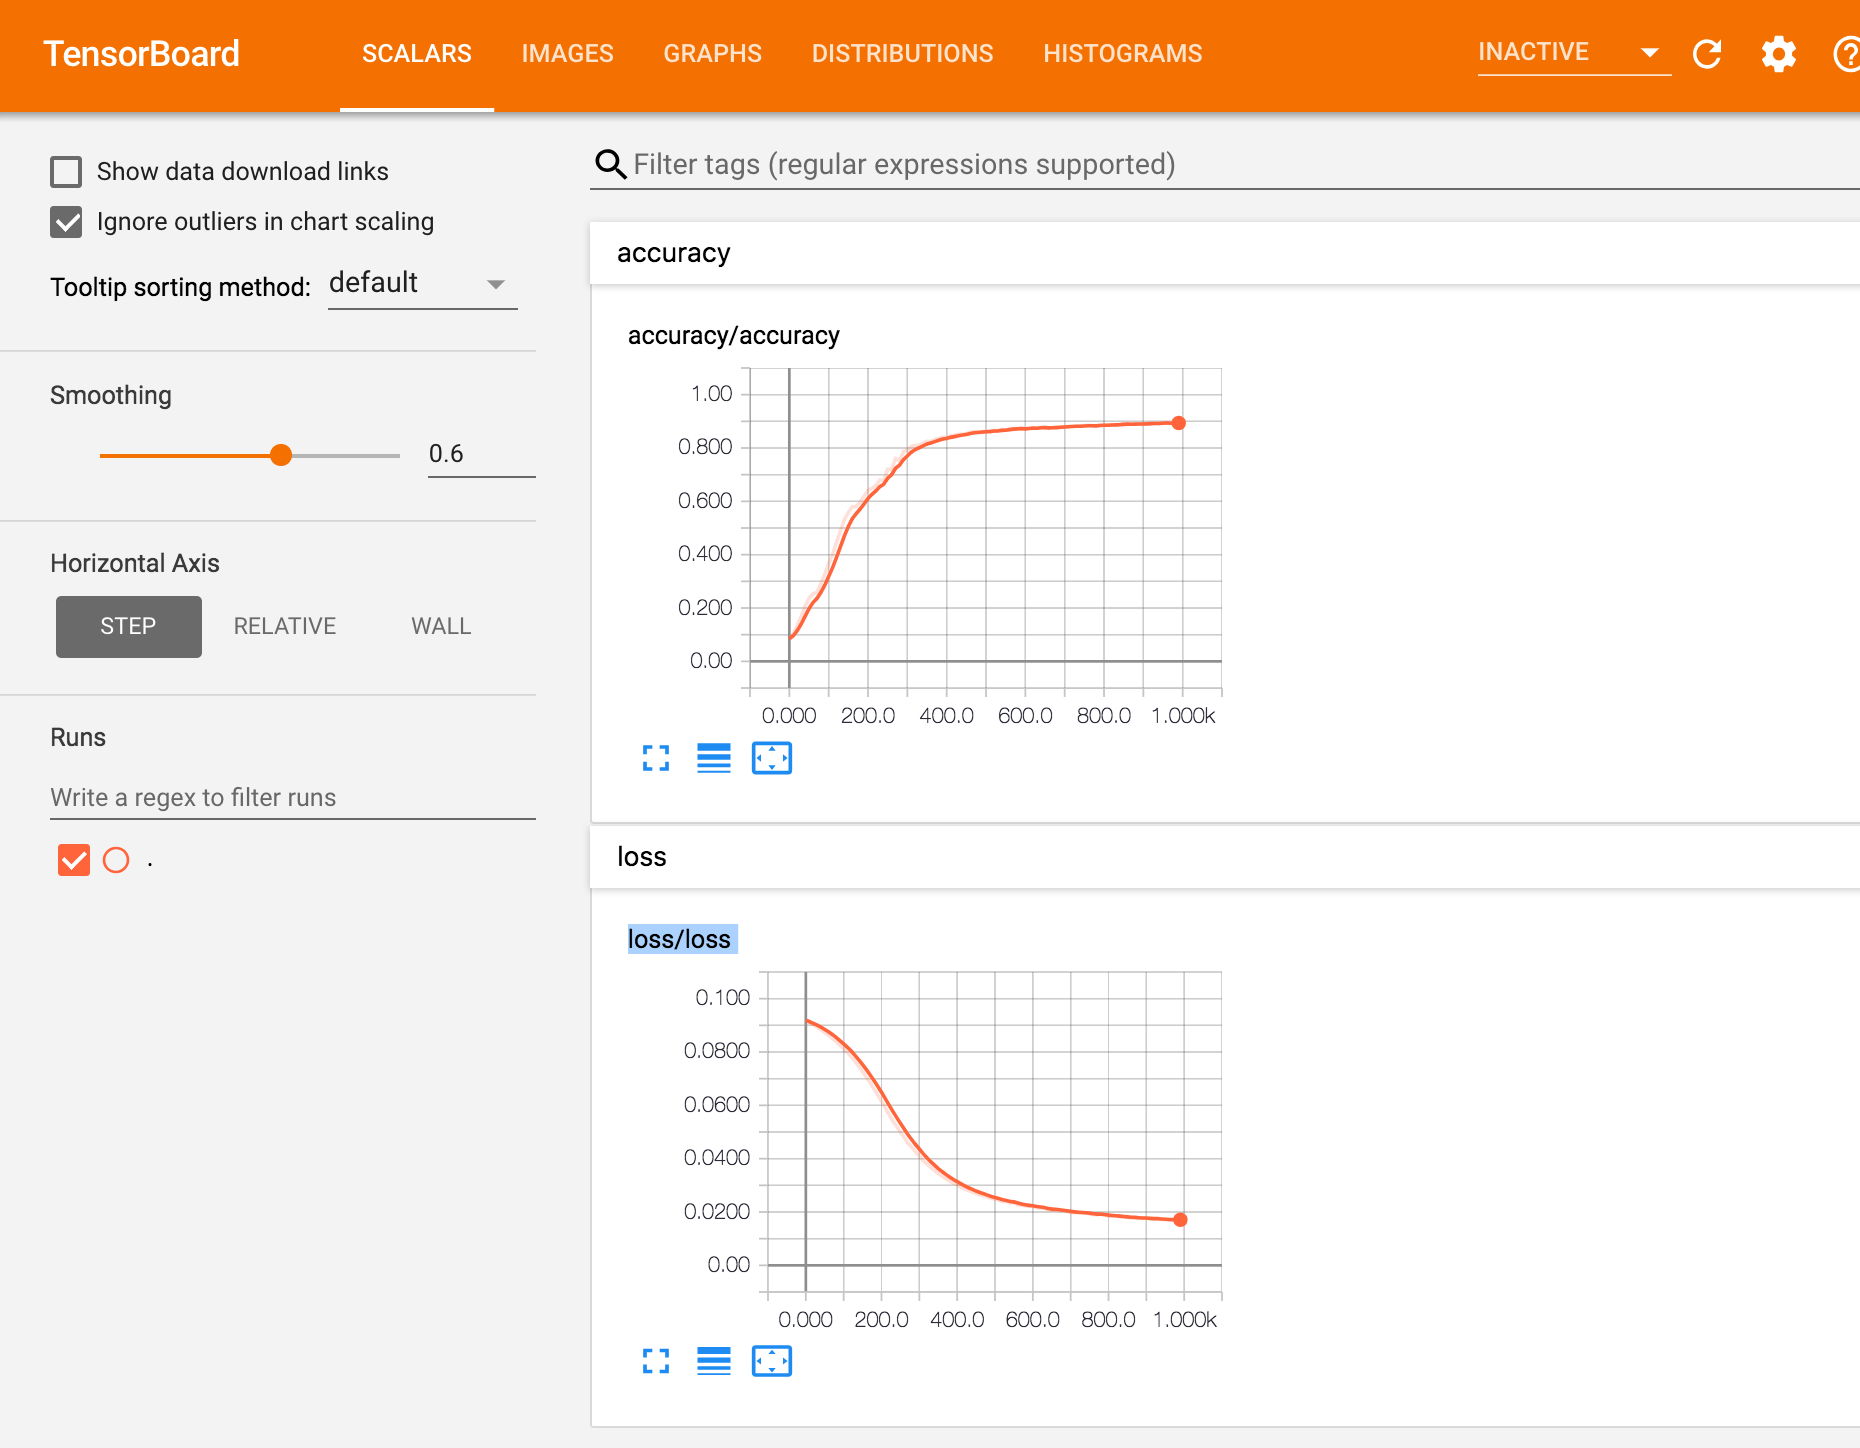

ニューラルネットワークの改善
---------------------
ニューラルネットワーク改善のアプローチ

- ニューラルネットワークを多層にする
- 畳み込みニューラルネットワークを導入する
- 誤差関数としてクロスエントロピーを用いる